In [1]:
import reeds
import pygromos

import glob
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats

from free_energy_funcs import direct_comparison, offset_comparison, additional_analysis, bootstrap_analysis_fromseed

/home/cchampion/programs/reeds/reeds/submodules/pygromos/pygromos/files/topology/top.py:20: UserWarning: Module topo-files is under Development and not entirely implemented!
  warnings.warn("Module topo-files is under Development and not entirely implemented!")


In [2]:
#1 Load the appropriate data

kis = np.array([0.0054, 0.18, 0.08, 0.073, 0.06, 0.032, 0.03, 0.026, 0.018, 0.009, 0.009, 0.002, 0.001]) * 1e-9

project_dir = os.getcwd()+'/data_for_plots/pim/free_energies_mbar/'

dg_wat_gaff_mbar = np.load(f'{project_dir}/PIM_water_gaff.npy')
dg_prot_gaff_mbar = np.load(f'{project_dir}/PIM_complex_gaff_no_seed4.npy')

dg_wat_openff_mbar = np.load(f'{project_dir}/PIM_water_openff.npy')
dg_prot_openff_mbar = np.load(f'{project_dir}/PIM_complex_openff.npy')


In [3]:
dgs_exp, dgs_sim_gaff_mbar = offset_comparison(kis, dg_prot_gaff_mbar, dg_wat_gaff_mbar)
dgs_exp , dgs_sim_openff_mbar = offset_comparison(kis, dg_prot_openff_mbar, dg_wat_openff_mbar)

In [4]:
np.round(dgs_exp, 2).T

array([-64.31, -55.62, -57.63, -57.86, -58.34, -59.9 , -60.06, -60.42,
       -61.33, -63.05, -63.05, -66.77, -68.49])

In [5]:
bootstrap_analysis_fromseed(dgs_sim_gaff_mbar[0], dgs_sim_gaff_mbar[1], dgs_exp, nboot=5000)

MUE = 4.6 [4.56 -- 4.71]
$\tau$ = 0.2 [0.15 -- 0.17]
$\rho$ = 0.3 [0.24 -- 0.27]
RMSE = 8.5 [8.37 -- 8.68]


In [6]:
bootstrap_analysis_fromseed(dgs_sim_openff_mbar[0], dgs_sim_openff_mbar[1], dgs_exp, nboot=5000)

MUE = 4.9 [4.83 -- 4.94]
$\tau$ = 0.3 [0.28 -- 0.30]
$\rho$ = 0.4 [0.44 -- 0.46]
RMSE = 8.6 [8.54 -- 8.71]


In [7]:
np.mean(np.abs(np.mean(dgs_exp) - dgs_exp))

2.9586930894195027

In [8]:
from free_energy_funcs import get_rel_ddGs

np.sqrt(np.mean(np.power(get_rel_ddGs(dgs_exp), 2) - 0)) # relative error compared to predicting only zeros

5.28305495050486

In [9]:
from free_energy_funcs import get_rel_ddGs

np.mean(np.abs(get_rel_ddGs(dgs_exp) - 0)) # relative error compared to predicting only zeros

4.370195481576892

In [10]:
from free_energy_funcs import get_rel_ddGs

In [11]:
ddgs_exp = get_rel_ddGs(dgs_exp)

In [12]:
np.mean(np.abs(np.mean(dgs_exp) - dgs_exp))

2.9586930894195027

In [13]:
np.sqrt(np.sum(np.power(ddgs_exp, 2)))

46.65867796652842

In [14]:
def plot_free_energies1(exp, sim, labels_sim, title=None, colors=None, markers=None,
                       two_greyed_regions=True, relative=False, manual_lims=None):
    """
    This function will plot the results in a square scatter plot
    
    """

    fontsize = 24 
    
    active_qualitative_map_mligs = lambda num_ligs: plt.cm.viridis(np.linspace(0,1,num_ligs))
    active_qualitative_map_mligs = lambda num_ligs: plt.cm.cividis(np.linspace(0,1,num_ligs))
    color_blind_frienfly = active_qualitative_map_mligs(5)

    def plot_errorbar(ax, x, y, y_err, color, label, zorder, alpha, marker = 's'):
        markers, caps, bars = ax.errorbar(x, y, y_err, fmt=marker, markersize = 10,
                                          color = color, mec = color,
                                          ecolor = color, label = label,
                                          capthick=1.5, capsize=4, linewidth = 3,
                                          zorder=zorder, alpha = alpha
                                         )
        [bar.set_alpha(1) for bar in bars]
        [cap.set_alpha(1) for cap in caps]

    xmin = np.min(exp)
    xmax = np.max(exp)


    color_blind_frienfly = ['#3388cc', '#bb1177']
    
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize =[9,9])

    if colors is None:
        colors = ['royalblue', 'firebrick', 'skyblue', 'darkorange']

    if markers is None:
        markers = ['D'] * len(labels_sim)

    if len(sim) == 2: # We we have gaff and openFF
        plot_errorbar(axes, exp, sim[0][0], sim[0][1], color = color_blind_frienfly[0],
                      label = labels_sim[0], zorder = 10, alpha = 0.85, marker = 's')

        plot_errorbar(axes, exp, sim[1][0], sim[1][1], color = color_blind_frienfly[1],
              label = labels_sim[1], zorder = 10, alpha = 0.85, marker = 's')

    else:
        for i, (s, label) in enumerate(zip(sim, labels_sim)):
            plot_errorbar(axes, exp, s[0], s[1], color = colors[i],
                          label = label, zorder = 10, alpha = 1, marker = markers[i])

        if np.min(s[0]) < xmin:
            xmin = np.min(s[0])
        if np.max(s[0]) > xmax:
            xmax = np.max(s[0])

    leg = axes.legend(loc = 'best', fontsize=fontsize, fancybox=True)
    leg.get_frame().set_edgecolor('black')

    x = np.linspace(-100, 100, 50)

    plt.plot(x, x, color = 'black')
    plt.plot(x, x-4.185, color = 'lightgrey')
    plt.plot(x, x+4.185, color = 'lightgrey')
    #
    plt.fill_between(x, x-4.185, x+4.185, color='lightgrey')

    if two_greyed_regions:
        plt.fill_between(x, x-2*4.185, x+2*4.185, color='lightgrey', alpha=0.5)

    if title is not None:
        plt.title(title, fontsize = 18)


    plt.xlabel(r'$\Delta G_{bind}$ - Experimental [kJ/mol]', fontsize = fontsize)
    plt.ylabel(r'$\Delta G_{bind}$ - RE-EDS [kJ/mol]', fontsize = fontsize)

    # Automatically find the value in x closest to largest and smallest values
    plot_max = np.min(x[x>xmax])
    plot_min = np.max(x[x<xmin])

    if manual_lims is None:
        axes.set_ylim([plot_min, plot_max])
        axes.set_xlim([plot_min, plot_max])
    else:
        axes.set_ylim(manual_lims)
        axes.set_xlim(manual_lims)
    # Formatting
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(1.5)

    axes.tick_params(axis="y",direction="in", length = 6, width = 1.5, labelsize=fontsize)
    axes.tick_params(axis="x",direction="in", length = 6, width = 1.5, labelsize=fontsize)

    return fig, axes

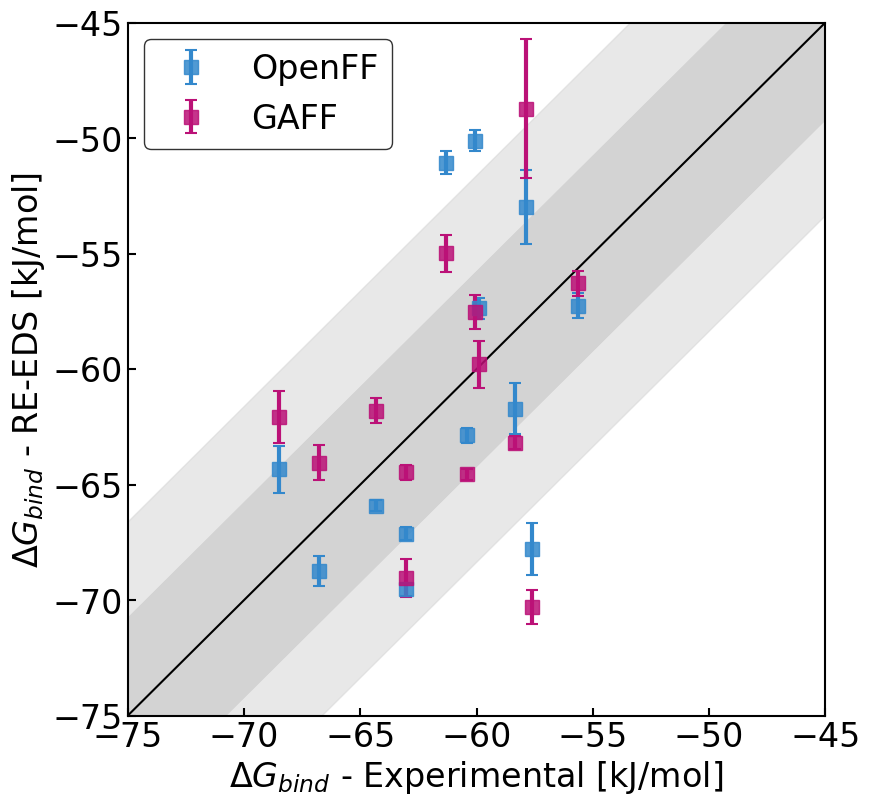

In [15]:
active_qualitative_map_mligs = lambda num_ligs: plt.cm.viridis(np.linspace(0,1,num_ligs))
c = active_qualitative_map_mligs(5)

labels_sim = ['OpenFF', 'GAFF']

fig, ax = plot_free_energies1(dgs_exp, sim=[dgs_sim_openff_mbar, dgs_sim_gaff_mbar], labels_sim = labels_sim, 
                         title =None, two_greyed_regions=True, manual_lims = [-75, -45], 
                         colors = [c[-1], c[1]],  markers= ['s', 's']                          
                            )

In [16]:
# fig.savefig('/cluster/home/cchampion/work/REEDS/PIM/figures/PIM_deltaGs.png', dpi=300, facecolor='white', bbox_inches='tight')